<a href="https://colab.research.google.com/github/emilyj19/TS/blob/master/SQF_RNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch

In [0]:
import numpy as np 
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
root_path = 'gdrive/My Drive/FinancialTS/JPmarket_dataset.npz' 
data = np.load(root_path)
data.files

['train_ratios', 'test_ratios', 'train_volumes', 'test_volumes']

In [0]:
train_ratios = data['train_ratios']
test_ratios = data['test_ratios']
train_vols = data['train_volumes']
test_vols = data['test_volumes']

In [0]:
#need to change this to create windows for all stocks 
def split_data(n_days, data): #data for one stock in the form [days, bins]
  no_ts = data.shape[0]-n_days
  length_ts = n_days*data.shape[1]
  new_data = np.zeros((no_ts,length_ts))
  for j in range(no_ts):
    for i in range(n_days): 
      new_data[j,64*i:64*i + 64] = data[j+i,:]
  
  return new_data

In [0]:
def make_test_data(train_data, test_data, n_days, stock_index):
  all_data = np.concatenate((train_data, test_data), axis = 1)
  
  one_data = all_data[stock_index]
  
  #now want to take only sets of n_days which contain the test data too 
  no_ts = test_data.shape[1]
  length_ts = n_days*one_data.shape[1]
  new_data = np.zeros((no_ts, length_ts))
  
  for j in range(no_ts): 
    for i in range(n_days): 
      new_data[j, 64*i:64*i + 64] = one_data[train_data.shape[1]+j-180+i+1,:]
      
  return new_data


testing_ratios = make_test_data(train_ratios, test_ratios, 180, 0)

In [0]:
def getbd_from_theta(theta): 
  gamma, beta, delta = theta
  
  L = len(beta)
  
  b = torch.zeros(L)
  for l in range(L): 
    if l == 0 : 
      b[l] = beta[l]
    else: 
      b[l] = beta[l]-beta[l-1]
  d = torch.zeros(L)
  for l in range(1,L): 
    d[l] = torch.sum(delta[:l])
    
  return b, d

In [0]:
def crps_loss(theta, z):
  
  gamma, beta, delta = theta
  
  L = len(beta)
  b, d = getbd_from_theta(theta)
  zeros = torch.zeros(L)
  
  if use_cuda and torch.cuda.is_available(): 
    b = b.cuda()
    d = d.cuda()
    zeros = zeros.cuda()
  
  lo = 0 
  for l in range(L-1, -1, -1): 
    val = sqf(theta, d[l])
    if val < z:
      lo = l
      break 
  
  a_tilde = (z-gamma + torch.sum(b[:lo]*d[:lo]))/torch.sum(b[:lo+1])
  
  max_ = torch.max(zeros+a_tilde, d)
  bracket = (1/3)*(1-torch.pow(d, 3)) - d - torch.pow(max_,2) + 2*max_*d
  loss = (2*a_tilde - 1)*z + (1-2*a_tilde)*gamma + torch.sum(b*bracket)
  
  return loss 

In [0]:
def sqf(theta, quantile): 
  
  gamma, beta, delta = theta
  L = len(beta)
  
  b,d = getbd_from_theta(theta)
    
  max_ = torch.max(quantile-d, torch.zeros(L))
  
  qf = gamma + torch.sum(b*max_)
  
  return qf

In [0]:
#create covariates - currently one hot vector 64 dims but experiment with different ideas 
def create_covariate_data(input_data, freq): #this is assuming that data starts at beginning of day and ends at last bin of the day 
  num_series, len_series = input_data.shape
  days = int(len_series/freq)
  covariate_vectors = np.zeros((num_series, len_series, freq+1))
  
  for n in range(num_series):
    for d in range(days): 
      for t in range(freq): 
        one_hot = np.zeros(freq)
        one_hot[t] = 1
        covariate_vectors[n, d*freq + t, 0] = input_data[n, d*freq + t]
        covariate_vectors[n, d*freq + t, 1:] = one_hot
        
  return covariate_vectors

In [0]:
#alternative covariate function 
#inputs - input_data of shape [number of time series, length of each time series], freq of data i.e. number of bins per day, and position of special bins as a vector
#returns - data and covariate vector of shape [number of series, length of series, number of special bins + 2] where covariate_vectors[:,:,0] is the input data, 
#covariate_vectors[:,:,1] is the scaled time of day and covariate_vectors[:,:,2:] is the one hot vector for the special bins
#therefore covariate_vectors[:,:,0] is the data and covariate_vectors[:,:,1:] is the actual covariate vector 

def new_create_covariate(input_data, freq, pos_of_special_bins): 
  num_series, len_series = input_data.shape
  days = int(len_series/freq)
  num_special_bins = len(pos_of_special_bins)
  covariate_vectors = np.zeros((num_series, len_series, num_special_bins+2))
  
  for n in range(num_series): 
    for d in range(days): 
      for t in range(freq): 
        x = np.zeros(num_special_bins + 1)
        #x[0] is the scaled time of day 
        x[0] = t/freq
        
        check = t in pos_of_special_bins
        
        if check == True: 
          index = pos_of_special_bins
          x[index+1] = 1
          
        covariate_vectors[n, d*freq + t, 0] = input_data[n, d*freq + t]
        covariate_vectors[n, d*freq + t, 1:] = x
        
  return covariate_vectors
        
        

In [2]:
my_list = [1,4,8]
t_f = 4 in my_list
print('tf', t_f)

tf True


In [0]:
class Encoder(nn.Module): 
  
  def __init__(self, input_size, hidden_size, batch_size, output_size, num_layers):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.output_size = output_size
    self.num_layers = num_layers
    
    self.lstm = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size, num_layers = self.num_layers)
    self.linear = nn.Linear(self.hidden_size, self.hidden_size)
    self.dense = nn.Linear(self.hidden_size, 1)
    self.softmax = nn.functional.softmax
    self.softplus = nn.functional.softplus
    
  def init_hidden(self): 
    return torch.zeros(self.num_layers, 1, self.hidden_size)
  
  def forward(self, data, hidden):
    lstm_out, hidden = self.lstm(data.view(1, 1, -1))
    fc_layer = self.linear(lstm_out.view(-1)) 
    delta = self.softmax(fc_layer)
    beta = self.softmax(fc_layer)
    gamma = self.dense(fc_layer)
    
    theta = (gamma, beta, delta)
    
    return theta, hidden 
  

In [0]:
learning_rate = 0.0005
#learning_rate_decay = 
num_epochs = 20
T = 64
num_paths = 50
pred_length = 64
num_lstm_layers = 2
hidden_units = 80
batch_size = 20
early_stop_patience = 2

In [0]:
#run if you want ratio data
training_data = split_data(int(T/64), train_ratios[0])
training_data.shape

small_data = np.zeros((20, training_data.shape[1]))
for i in range(small_data.shape[0]): 
  index = np.random.randint(0, training_data.shape[0])
  small_data[i,:] = training_data[index]
  
small_data_new = torch.FloatTensor(small_data)

In [0]:
#run if you want volume data
training_data = split_data(int(T/64), train_vols[0])
train_volume = training_data/np.amax(train_vols[0]) #Normalize data

small_data = np.zeros((20, train_volume.shape[1]))
for i in range(small_data.shape[0]): 
  index = np.random.randint(0, training_data.shape[0])
  small_data[i,:] = train_volume[index]
  
small_data_new = torch.FloatTensor(small_data)

In [0]:
covars = create_covariate_data(small_data, 64) #matrix of covariates corresponding to the input data 
train_data_covs = torch.FloatTensor(covars)

In [17]:
encoder = Encoder(65, hidden_units, batch_size, 1, num_lstm_layers)
print(encoder)

Encoder(
  (lstm): LSTM(65, 80, num_layers=2)
  (linear): Linear(in_features=80, out_features=80, bias=True)
  (dense): Linear(in_features=80, out_features=1, bias=True)
)


In [0]:
use_cuda = False
if use_cuda and torch.cuda.is_available():
    encoder.cuda()

In [19]:
### TRAINING the encoder###

##Question: should optimization be done on each time series or over loss for all TS?
loss_function = crps_loss
encoder_optimiser = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
train_loss = []
early_stop_count = 0

for i in range(num_epochs): 
  encoder.zero_grad()
  encoder_hidden = encoder.init_hidden()
  
  batch_loss = 0
  
  data_batch = train_data_covs #change this when using larger dataset 
  
  data_batch = Variable(data_batch)
  
  if use_cuda and torch.cuda.is_available():
    data_batch = data_batch.cuda()
  
  for j in range(batch_size):
    loss_t = 0 
    input_data = data_batch[j]
    
    for t in range(T-1): 
      theta, encoder_hidden = encoder(input_data[t:t+1], encoder_hidden)
      loss_t += loss_function(theta, input_data[t+1:t+2,0])
   
    batch_loss+= loss_t
    
  loss_batch = batch_loss 
    
  encoder_optimiser.zero_grad()
  
  batch_loss.backward()

  encoder_optimiser.step()

  train_loss.append(batch_loss.item())
  
  #early stopping
  if train_loss[i] > train_loss[i-1]: 
    early_stop_count += 1
    if early_stop_count == early_stop_patience:
      break
    
  #add a test loss here too
  
  print("Epoch ", i, "CRPS ", batch_loss.item())
  
  torch.cuda.empty_cache() 
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch  0 CRPS  755.1250610351562
Epoch  1 CRPS  516.1189575195312
Epoch  2 CRPS  328.8995666503906
Epoch  3 CRPS  192.1734619140625
Epoch  4 CRPS  102.71480560302734
Epoch  5 CRPS  54.38868713378906
Epoch  6 CRPS  38.05575942993164
Epoch  7 CRPS  42.32856750488281


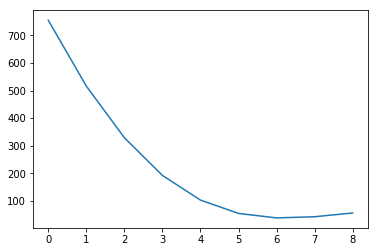

In [20]:
plt.plot(train_loss)


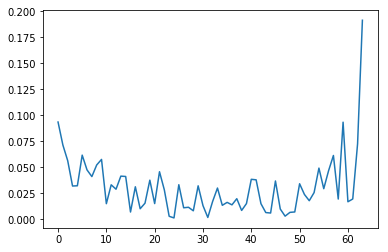

In [21]:
#test data 
test_data = test_vols[0, 0:int(T/64)]
test_data = test_data.reshape((test_data))
test_data_norm = test_data/np.amax(test_vols[0])

plt.plot(test_data_norm)

In [0]:
test_data = test_data_norm.reshape((1,-1))

covars = create_covariate_data(test_data, 64)

input_test_data = torch.FloatTensor(covars)
input_test_data = input_test_data[0]

In [23]:
## PREDICTION ## this is for one example rather than a batch of test data so far 
decoder = encoder
paths = np.zeros((num_paths, T + pred_length))

with torch.no_grad(): 
  input_data = input_test_data
  for t in range(T): 
    theta, encoder_hidden = encoder(input_test_data[t], encoder_hidden)
    #print(t, encoder_hidden)
    
  for n in range(num_paths): 
  
    decoder_input = input_test_data[T-1]
    decoder_hidden = encoder_hidden 
    sample_path = np.zeros(pred_length)

    for i in range(pred_length): 
      theta, decoder_hidden = decoder(decoder_input, decoder_hidden)
      alpha = torch.distributions.uniform.Uniform(0,1).rsample()
      z_hat = sqf(theta, alpha)
      sample_path[i] = z_hat.item()
      one_hot = torch.zeros(65)
      one_hot[0] = z_hat
      one_hot[i+1] = 1
      decoder_input = one_hot
      
    paths[n,:T] = input_test_data[:,0]
    paths[n, T:] = sample_path


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [25]:
paths[0, T:]

array([0.02932895, 0.03231969, 0.02387534, 0.02896571, 0.02239065,
       0.03265097, 0.0243155 , 0.02041849, 0.02731518, 0.02893854,
       0.03298277, 0.02576179, 0.02558628, 0.03214137, 0.02636553,
       0.02933184, 0.02552427, 0.02366467, 0.03143455, 0.02149331,
       0.02275421, 0.02719089, 0.02977835, 0.02546998, 0.02492402,
       0.0233366 , 0.02836309, 0.02706724, 0.03141326, 0.02469097,
       0.02887988, 0.03366983, 0.03122307, 0.03025094, 0.02451329,
       0.02701245, 0.02395836, 0.02689922, 0.02453906, 0.02158214,
       0.02620604, 0.02415145, 0.02708109, 0.03355415, 0.02419687,
       0.02263409, 0.02473004, 0.02550423, 0.03480277, 0.02449419,
       0.03115232, 0.02553424, 0.03271205, 0.02920112, 0.0244967 ,
       0.03286415, 0.03083093, 0.03188657, 0.02137436, 0.02577842,
       0.02550458, 0.02237712, 0.02226806, 0.022185  ])

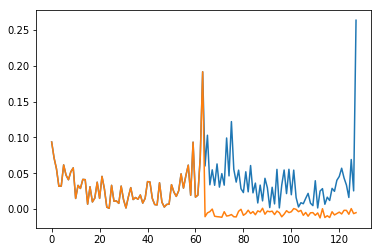

In [30]:
plt.plot(actual_test_data_norm)
plt.plot(paths[12])

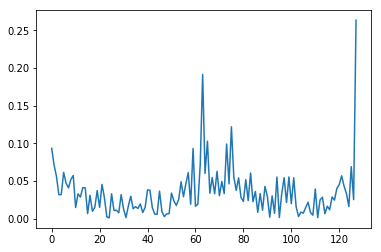

In [24]:
actual_test_data = test_vols[0,0:int(T/64)+1]
actual_test_data = actual_test_data.flatten()
actual_test_data_norm = actual_test_data/np.amax(test_vols[0])

plt.plot(actual_test_data_norm)

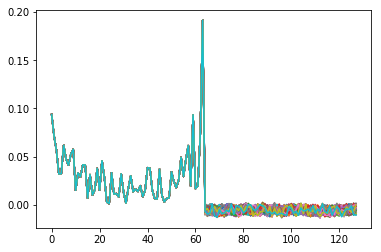

In [26]:
for i in range(num_paths): 
  plt.plot(paths[i])